In [8]:
import pandas as pd
import os
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('cleaned_football_data.csv')

# Split data by league and season
serie_a_data = data[data['League'] == 'Serie A']
pl_data = data[data['League'] == 'Premier League']

display(serie_a_data.head())
display(pl_data.head())

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AvgA,PSCH,PSCD,PSCA,Season,League,LBH,LBD,LBA,HomeWin
3040,I1,24/08/2019,Parma,Juventus,0,1,A,0.0,1.0,A,...,1.31,9.60,5.20,1.37,2019,Serie A,2.87875,4.095724,5.192526,0
3041,I1,24/08/2019,Fiorentina,Napoli,3,4,A,1.0,2.0,A,...,1.76,4.52,3.72,1.85,2019,Serie A,2.87875,4.095724,5.192526,0
3042,I1,25/08/2019,Udinese,Milan,1,0,H,0.0,0.0,D,...,2.06,4.03,3.43,2.04,2019,Serie A,2.87875,4.095724,5.192526,1
3043,I1,25/08/2019,Cagliari,Brescia,0,1,A,0.0,0.0,D,...,4.45,1.83,3.67,4.75,2019,Serie A,2.87875,4.095724,5.192526,0
3044,I1,25/08/2019,Roma,Genoa,3,3,D,2.0,2.0,D,...,7.13,1.75,3.69,5.32,2019,Serie A,2.87875,4.095724,5.192526,0


,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AvgA,PSCH,PSCD,PSCA,Season,League,LBH,LBD,LBA,HomeWin
0,E0,09/08/2019,Liverpool,Norwich,4,1,H,4.0,0.0,H,...,19.83,1.14,10.43,19.63,2019,Premier League,2.953658,4.099487,5.155421,1
1,E0,10/08/2019,West Ham,Man City,0,5,A,0.0,1.0,A,...,1.25,11.11,6.68,1.27,2019,Premier League,2.953658,4.099487,5.155421,0
2,E0,10/08/2019,Bournemouth,Sheffield United,1,1,D,0.0,0.0,D,...,3.83,1.98,3.67,4.06,2019,Premier League,2.953658,4.099487,5.155421,0
3,E0,10/08/2019,Burnley,Southampton,3,0,H,0.0,0.0,D,...,2.78,2.71,3.19,2.90,2019,Premier League,2.953658,4.099487,5.155421,1
4,E0,10/08/2019,Crystal Palace,Everton,0,0,D,0.0,0.0,D,...,2.40,3.37,3.45,2.27,2019,Premier League,2.953658,4.099487,5.155421,0


---
### Hypothesis Testing `1`: Does the Premier League Have a Home-Field Advantage?

We are testing if the **Premier League (PL)** has a **significantly higher home-team advantage** compared to **Serie A**.

- **Null Hypothesis (H₀)**: There is no significant difference in home-team advantage between the Premier League and Serie A, or Serie A has a higher home-team advantage.  
  
  $ H_0: \mu_{PL} - \mu_{Serie A} \leq 0 $

- **Alternative Hypothesis (H₁)**: The Premier League has a **significantly higher home-team advantage** than Serie A.  
  
  $ H_1: \mu_{PL} - \mu_{Serie A} > 0 $

This is a **right-tailed test**, where we are testing if the **home win proportion** in the Premier League is **significantly greater** than that in Serie A.

---

### Test Setup:

- **Difference**: We calculate the difference between the **home-team win proportions** for Premier League and Serie A:  

  $ \text{Difference} = p_{PL} - p_{Serie A} $

- **Region of Practical Equivalence (ROPE)**:  
  We define a **ROPE** to assess if the difference falls within a range that would be considered practically equivalent:  
  **ROPE**: (-0.05, 0.05), meaning we are open to considering small differences as insignificant.

---

### Decision Criteria:

- **Reject H₀** if the **difference** is significantly greater than **0.05** (i.e., if the Premier League has a **significantly higher home win proportion** than Serie A).
- **Fail to Reject H₀** if the **difference** falls within the **ROPE** (-0.05, 0.05), indicating no practical difference.
  

---

#### Choice of the Prior  
We compared two sets of prior parameters: $ \alpha = 4 $ , $ \beta = 6 $, and  $\alpha = 20 $, $\beta = 25 $. The first prior represents a belief that home win probabilities are expected to be around 0.45, with a relatively uninformative distribution and mild concentration around the expected value. The second prior, with $ \alpha = 20 $ and $ \beta = 25 $, reflects a stronger belief centered around 0.44, with tighter concentration. Comparing these priors allows us to evaluate the sensitivity of the results to different assumptions about home win probabilities.  

---


### Step 1: Initialize Variables and Constants

Here, we initialize the seasons and lists to store our posterior analysis results, including the home win proportions for both leagues and hypothesis testing variables.


In [5]:
# Initialize lists for results
posterior_means_serie_a_sensitive = []
posterior_means_pl_sensitive = []
posterior_diffs_sensitive = []

posterior_means_serie_a_non_sensitive = []
posterior_means_pl_non_sensitive = []
posterior_diffs_non_sensitive = []

# Iterate over seasons
seasons = serie_a_data['Season'].unique()  # Assuming you have the dataset loaded
seasons = np.sort(seasons)
# Hypothesis testing variables
pl_higher_probs = []
serie_a_higher_probs = []
in_rope_data = []
rope = (-0.05, 0.05)  # ROPE definition

---

### Step 2: Helper Functions

We define two key functions:
1. **`get_season_data`**: This function extracts the total number of matches and home wins for each season in both Serie A and the Premier League.
2. **`run_bayesian_model_with_priors`**: This function defines and runs the Bayesian model using either a sensitive or non-sensitive prior.


In [6]:
# Function to extract season-specific data
def get_season_data(serie_a_season, pl_season):
    n_serie_a = serie_a_season.shape[0]  # Total matches
    wins_serie_a = (serie_a_season['FTR'] == 'H').sum()  # Home wins in Serie A
    n_pl = pl_season.shape[0]  # Total matches
    wins_pl = (pl_season['FTR'] == 'H').sum()  # Home wins in PL
    return n_serie_a, wins_serie_a, n_pl, wins_pl

# Modify the sampling part to ensure rng is properly handled
def run_bayesian_model_with_priors(n_serie_a, wins_serie_a, n_pl, wins_pl, prior_type='non_sensitive'):
    with pm.Model() as model:
        # Define priors based on the type
        if prior_type == 'sensitive':
            p_serie_a = pm.Beta('p_serie_a', alpha=20, beta=25)  # More informative prior
            p_pl = pm.Beta('p_pl', alpha=20, beta=25)  # More informative prior
        else:
            p_serie_a = pm.Beta('p_serie_a', alpha=4, beta=6)  # Non-informative prior
            p_pl = pm.Beta('p_pl', alpha=4, beta=6)  # Non-informative prior

        # Binomial likelihood
        home_wins_serie_a = pm.Binomial('home_wins_serie_a', n=n_serie_a, p=p_serie_a, observed=wins_serie_a)
        home_wins_pl = pm.Binomial('home_wins_pl', n=n_pl, p=p_pl, observed=wins_pl)

        # Use numpy default random generator for sampling
        trace = pm.sample(2000, return_inferencedata=False)

    return trace

---


### Step 3: Run Bayesian Analysis for Each Season

In this step, we iterate through each season to extract match data, run Bayesian models with both priors, and collect the posterior samples. The results will help us analyze the home win proportions in each league.


In [ ]:
# Initialize lists for results
posterior_means_serie_a_sensitive = []
posterior_means_pl_sensitive = []
posterior_diffs_sensitive = []

posterior_means_serie_a_non_sensitive = []
posterior_means_pl_non_sensitive = []
posterior_diffs_non_sensitive = []

# Iterate over seasons
seasons = serie_a_data['Season'].unique()  # Assuming you have the dataset loaded
seasons = np.sort(seasons)
# Hypothesis testing variables
pl_higher_probs = []
serie_a_higher_probs = []
in_rope_data = []
rope = (-0.05, 0.05)  # ROPE definition
# Initialize lists to store posterior traces
trace_sensitive_serie_a = []
trace_sensitive_pl = []
trace_non_sensitive_serie_a = []
trace_non_sensitive_pl = []

# Iterate over seasons
for season in seasons:
    # Filter data for the season
    serie_a_season = serie_a_data[serie_a_data['Season'] == season]
    pl_season = pl_data[pl_data['Season'] == season]

    # Get season-specific data
    n_serie_a, wins_serie_a, n_pl, wins_pl = get_season_data(serie_a_season, pl_season)

    # Run Bayesian models with both priors (sensitive and non-sensitive)
    trace_sensitive = run_bayesian_model_with_priors(n_serie_a, wins_serie_a, n_pl, wins_pl, prior_type='sensitive')
    trace_non_sensitive = run_bayesian_model_with_priors(n_serie_a, wins_serie_a, n_pl, wins_pl, prior_type='non_sensitive')

    # Extract posterior samples
    p_serie_a_samples_sensitive = trace_sensitive['p_serie_a']
    p_pl_samples_sensitive = trace_sensitive['p_pl']
    difference_samples_sensitive = p_pl_samples_sensitive - p_serie_a_samples_sensitive

    p_serie_a_samples_non_sensitive = trace_non_sensitive['p_serie_a']
    p_pl_samples_non_sensitive = trace_non_sensitive['p_pl']
    difference_samples_non_sensitive = p_pl_samples_non_sensitive - p_serie_a_samples_non_sensitive

    # Store posterior traces for later use
    trace_sensitive_serie_a.append(p_serie_a_samples_sensitive)
    trace_sensitive_pl.append(p_pl_samples_sensitive)
    trace_non_sensitive_serie_a.append(p_serie_a_samples_non_sensitive)
    trace_non_sensitive_pl.append(p_pl_samples_non_sensitive)

    # Store the posterior means for the DataFrame
    posterior_means_serie_a_sensitive.append(np.mean(p_serie_a_samples_sensitive))
    posterior_means_pl_sensitive.append(np.mean(p_pl_samples_sensitive))
    posterior_diffs_sensitive.append(np.mean(difference_samples_sensitive))

    posterior_means_serie_a_non_sensitive.append(np.mean(p_serie_a_samples_non_sensitive))
    posterior_means_pl_non_sensitive.append(np.mean(p_pl_samples_non_sensitive))
    posterior_diffs_non_sensitive.append(np.mean(difference_samples_non_sensitive))

# Create DataFrame with results
results = pd.DataFrame({
    'Season': seasons,
    'Serie_A_Mean_Sensitive': posterior_means_serie_a_sensitive,
    'PL_Mean_Sensitive': posterior_means_pl_sensitive,
    'Difference_Sensitive': posterior_diffs_sensitive,
    'Serie_A_Mean_Non_Sensitive': posterior_means_serie_a_non_sensitive,
    'PL_Mean_Non_Sensitive': posterior_means_pl_non_sensitive,
    'Difference_Non_Sensitive': posterior_diffs_non_sensitive
})

# Sort results by season
results.sort_values(by='Season', inplace=True)

---

### Step 4: Posterior Analysis and Plotting

Now that we have collected the posterior samples for both priors, we can plot the posterior means of the home win proportions for both Serie A and Premier League.


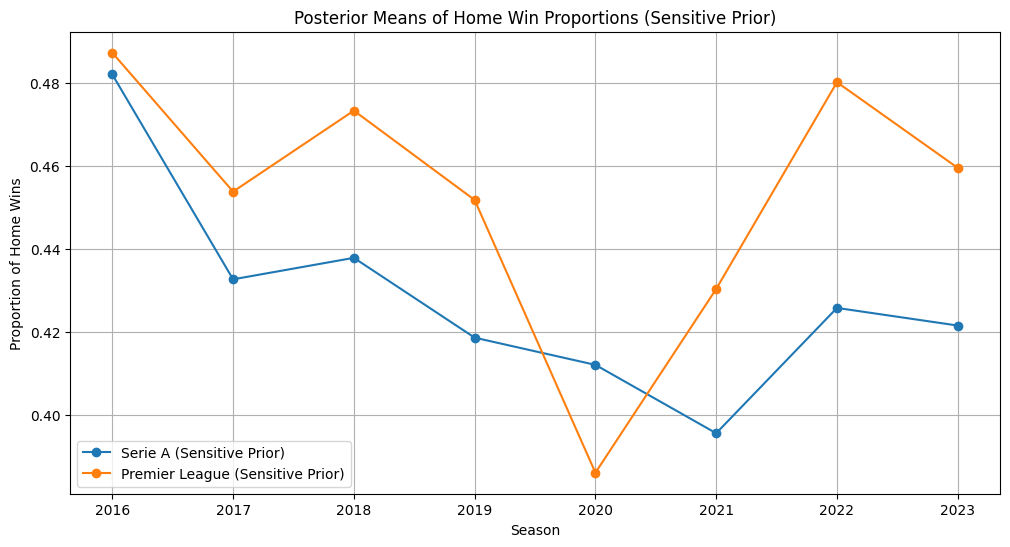

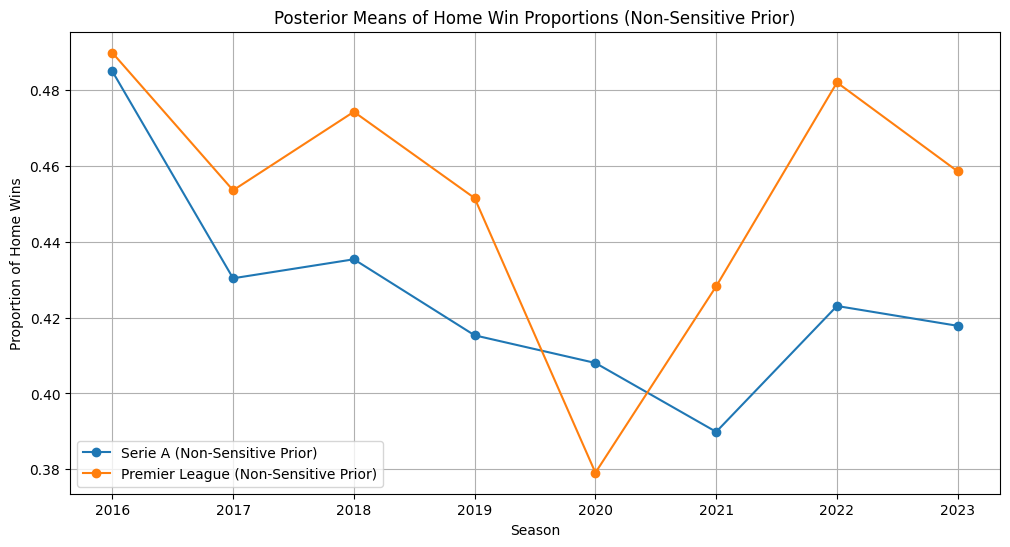

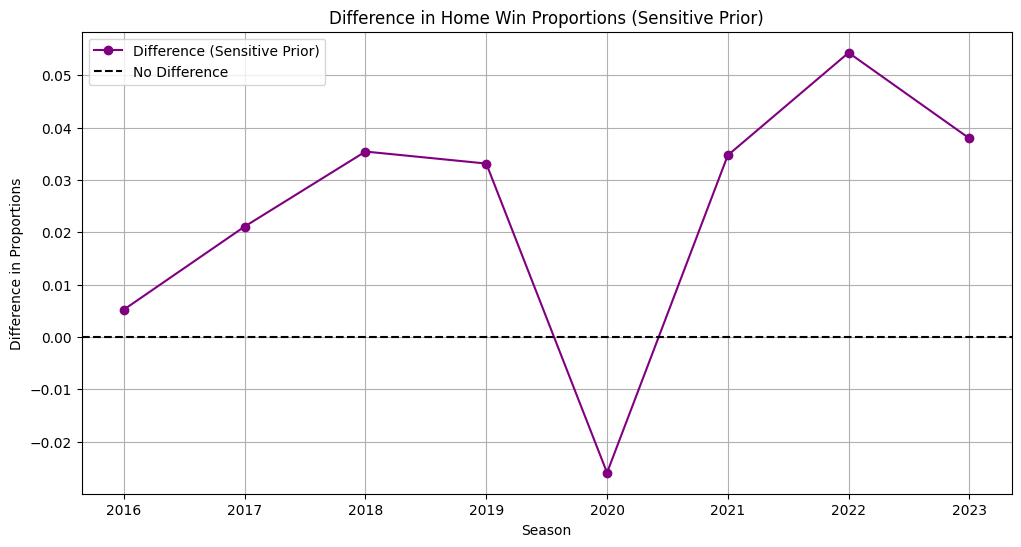

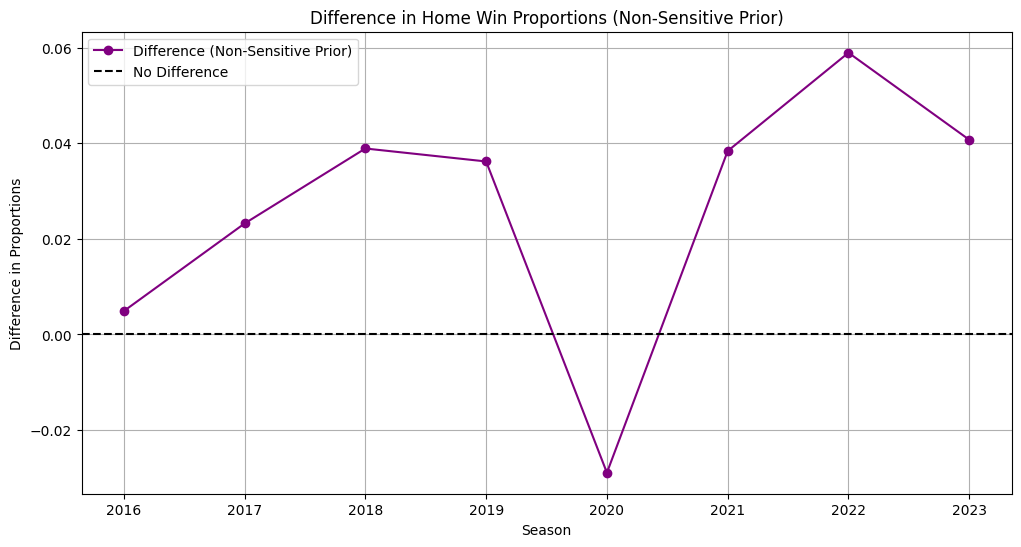

In [10]:
# Plot posterior means for sensitive and non-sensitive priors
plt.figure(figsize=(12, 6))
plt.plot(results['Season'], results['Serie_A_Mean_Sensitive'], marker='o', label='Serie A (Sensitive Prior)')
plt.plot(results['Season'], results['PL_Mean_Sensitive'], marker='o', label='Premier League (Sensitive Prior)')
plt.title('Posterior Means of Home Win Proportions (Sensitive Prior)')
plt.xlabel('Season')
plt.ylabel('Proportion of Home Wins')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(results['Season'], results['Serie_A_Mean_Non_Sensitive'], marker='o', label='Serie A (Non-Sensitive Prior)')
plt.plot(results['Season'], results['PL_Mean_Non_Sensitive'], marker='o', label='Premier League (Non-Sensitive Prior)')
plt.title('Posterior Means of Home Win Proportions (Non-Sensitive Prior)')
plt.xlabel('Season')
plt.ylabel('Proportion of Home Wins')
plt.legend()
plt.grid()
plt.show()

# Plot differences across seasons for both priors
plt.figure(figsize=(12, 6))
plt.plot(results['Season'], results['Difference_Sensitive'], marker='o', color='purple', label='Difference (Sensitive Prior)')
plt.axhline(0, color='black', linestyle='--', label='No Difference')
plt.title('Difference in Home Win Proportions (Sensitive Prior)')
plt.xlabel('Season')
plt.ylabel('Difference in Proportions')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(results['Season'], results['Difference_Non_Sensitive'], marker='o', color='purple', label='Difference (Non-Sensitive Prior)')
plt.axhline(0, color='black', linestyle='--', label='No Difference')
plt.title('Difference in Home Win Proportions (Non-Sensitive Prior)')
plt.xlabel('Season')
plt.ylabel('Difference in Proportions')
plt.legend()
plt.grid()
plt.show()

---

### Step 5: Plotting Posterior Distributions for the Difference in Home Win Proportions Between Premier League and Serie A

In this section, we plot the posterior distributions of the difference in home win proportions between Serie A and Premier League for each season. We use both sensitive and non-sensitive priors to compare the results. Each subplot includes the mean difference and highlights the ROPE (Region of Practical Equivalence) to help visualize the proportion of samples that fall within the ROPE for each season.


In [11]:
seasons

array([2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023], dtype=int64)

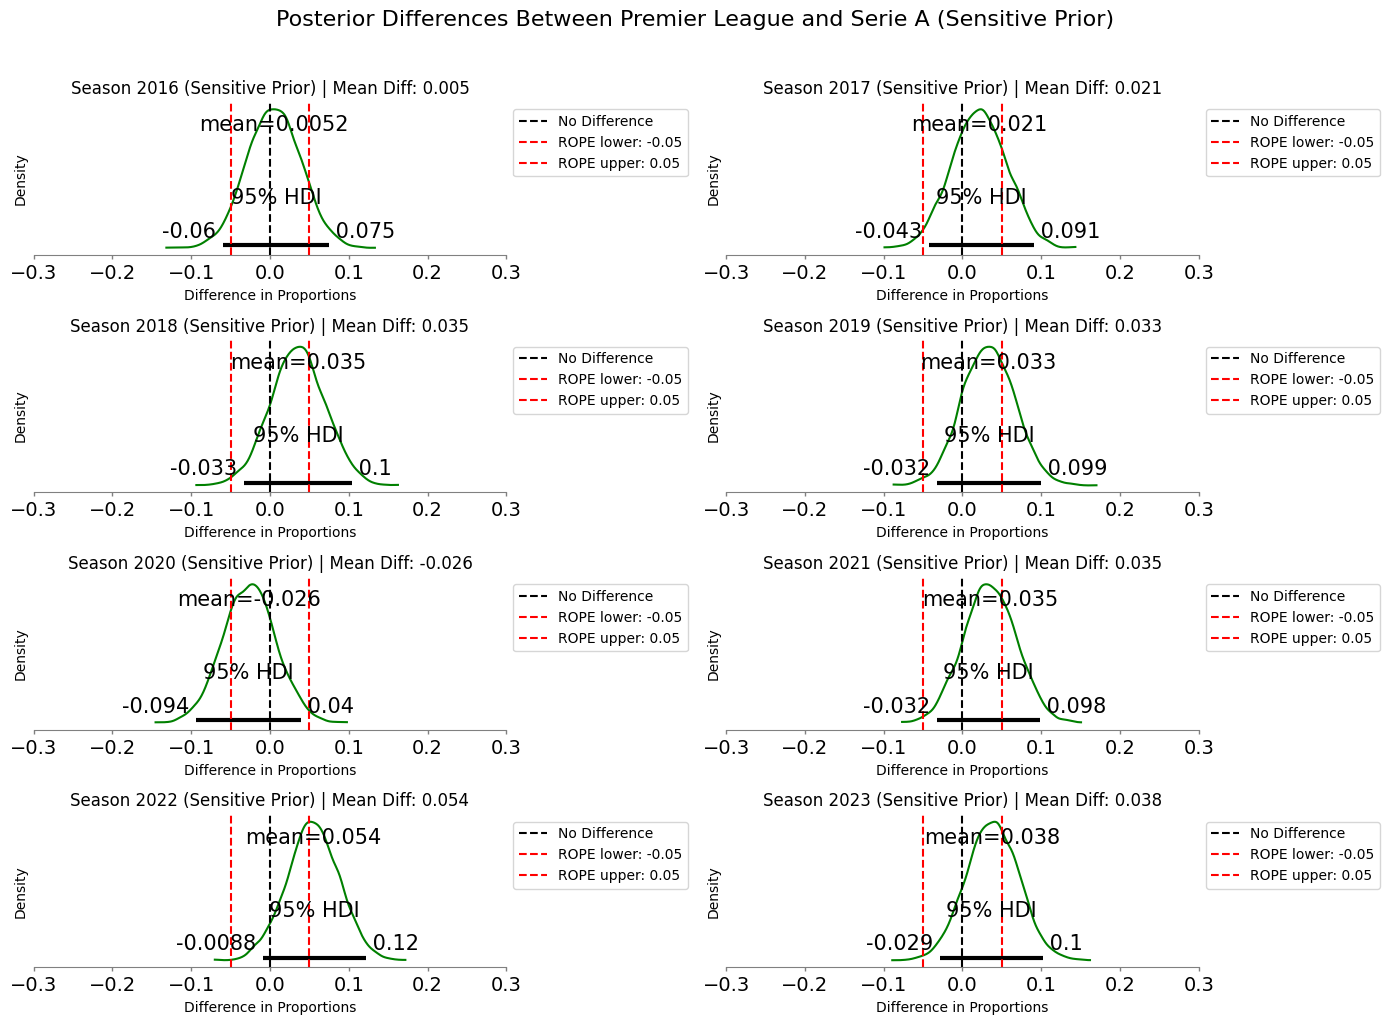

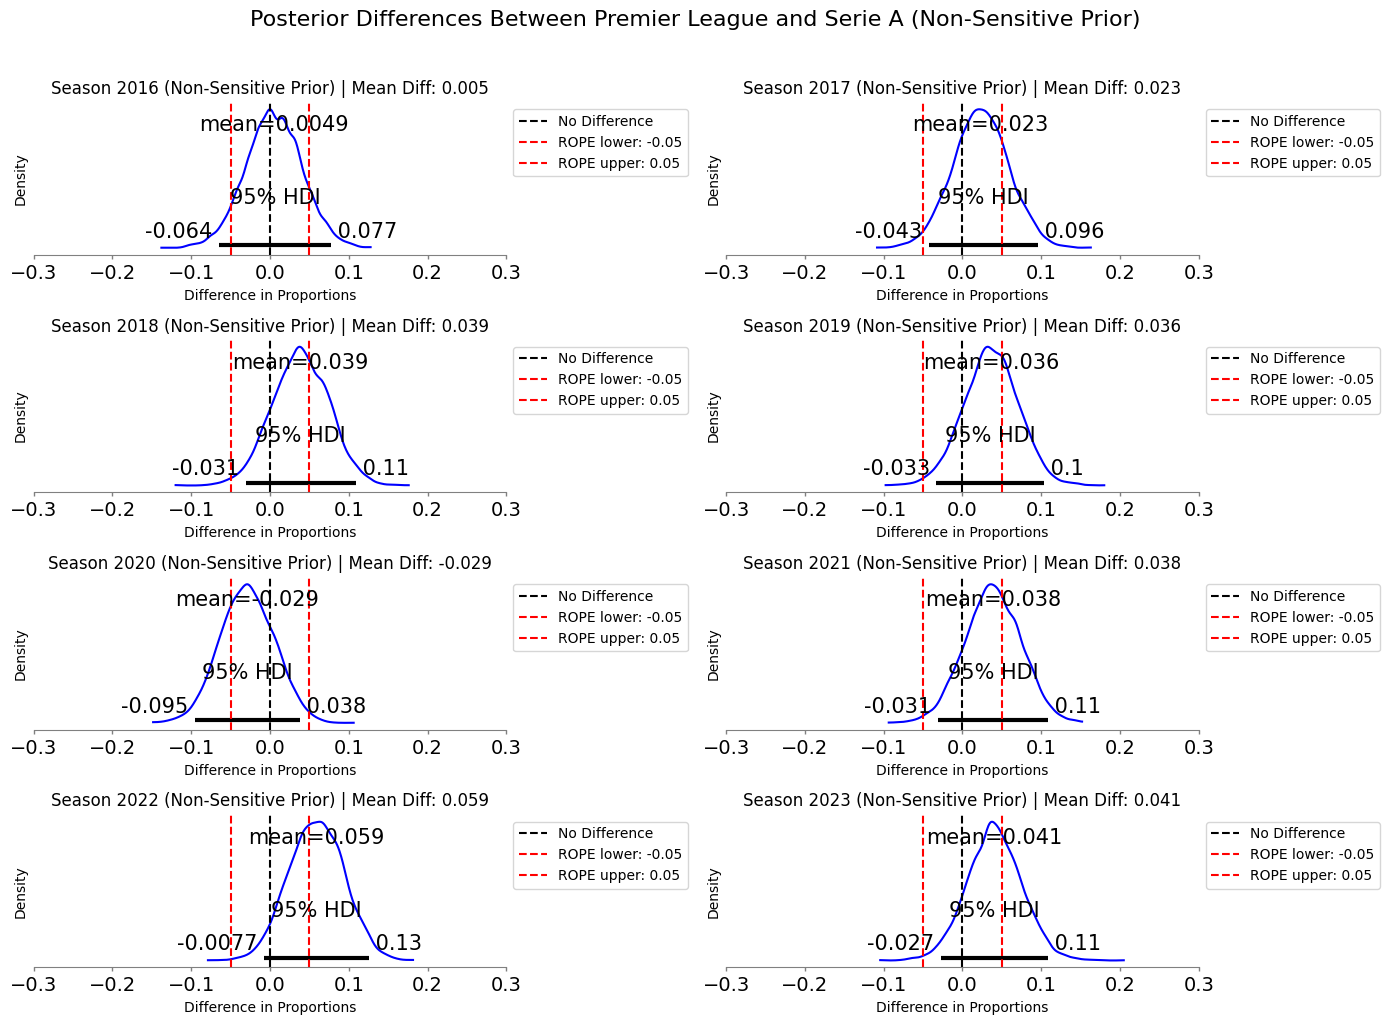

In [12]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

# Define the rope limits
rope = (-0.05, 0.05)

pl_higher_probs_sensitive = []
serie_a_higher_probs_sensitive = []
in_rope_data_sensitive = []

pl_higher_probs_non_sensitive = []
serie_a_higher_probs_non_sensitive = []
in_rope_data_non_sensitive = []

# Plot posterior distributions for sensitive prior (Serie A vs Premier League)
plt.figure(figsize=(14, 10))

for idx, season in enumerate(seasons):
    plt.subplot(len(seasons) // 2 + len(seasons) % 2, 2, idx + 1)
    # Plot posterior distribution of the difference between PL and Serie A for sensitive prior
    difference_samples_sensitive = trace_sensitive_pl[idx] - trace_sensitive_serie_a[idx]
    az.plot_posterior(difference_samples_sensitive, hdi_prob=0.95, color='green', ax=plt.gca())
    plt.xlabel('Difference in Proportions')
    plt.ylabel('Density')
    plt.xlim(-0.3, 0.3)
    plt.axvline(0, color='black', linestyle='--', label='No Difference')
    plt.axvline(rope[0], color='red', linestyle='--', label=f'ROPE lower: {rope[0]}')
    plt.axvline(rope[1], color='red', linestyle='--', label=f'ROPE upper: {rope[1]}')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

    # Calculate the probability of PL > Serie A and Serie A > PL for sensitive prior
    pl_higher_prob_sensitive = np.mean(difference_samples_sensitive > 0.05)
    serie_a_higher_prob_sensitive = np.mean(difference_samples_sensitive < -0.05)

    # Calculate proportion of difference samples in the ROPE
    in_rope_sensitive = np.sum((difference_samples_sensitive >= rope[0]) & (difference_samples_sensitive <= rope[1])) / len(difference_samples_sensitive)

    # Store the results
    pl_higher_probs_sensitive.append(pl_higher_prob_sensitive)
    serie_a_higher_probs_sensitive.append(serie_a_higher_prob_sensitive)
    in_rope_data_sensitive.append(in_rope_sensitive)

    # Calculate the mean difference for the title
    mean_diff_sensitive = np.mean(difference_samples_sensitive)

    # Add mean to title for better visualization (in the title only, no extra line on the plot)
    plt.title(f"Season {season} (Sensitive Prior) | Mean Diff: {mean_diff_sensitive:.3f}")

# Add overarching title for sensitive prior plot
plt.suptitle('Posterior Differences Between Premier League and Serie A (Sensitive Prior)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Plot posterior distributions for non-sensitive prior (Serie A vs Premier League)
plt.figure(figsize=(14, 10))

for idx, season in enumerate(seasons):
    plt.subplot(len(seasons) // 2 + len(seasons) % 2, 2, idx + 1)
    # Plot posterior distribution of the difference between PL and Serie A for non-sensitive prior
    difference_samples_non_sensitive = trace_non_sensitive_pl[idx] - trace_non_sensitive_serie_a[idx]
    az.plot_posterior(difference_samples_non_sensitive, hdi_prob=0.95, color='blue', ax=plt.gca())
    plt.xlabel('Difference in Proportions')
    plt.ylabel('Density')
    plt.xlim(-0.3, 0.3)
    plt.axvline(0, color='black', linestyle='--', label='No Difference')
    plt.axvline(rope[0], color='red', linestyle='--', label=f'ROPE lower: {rope[0]}')
    plt.axvline(rope[1], color='red', linestyle='--', label=f'ROPE upper: {rope[1]}')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

    # Calculate the probability of PL > Serie A and Serie A > PL for non-sensitive prior
    pl_higher_prob_non_sensitive = np.mean(difference_samples_non_sensitive > 0.05)
    serie_a_higher_prob_non_sensitive = np.mean(difference_samples_non_sensitive < -0.05)

    # Calculate proportion of difference samples in the ROPE
    in_rope_non_sensitive = np.sum((difference_samples_non_sensitive >= rope[0]) & (difference_samples_non_sensitive <= rope[1])) / len(difference_samples_non_sensitive)

    # Store the results
    pl_higher_probs_non_sensitive.append(pl_higher_prob_non_sensitive)
    serie_a_higher_probs_non_sensitive.append(serie_a_higher_prob_non_sensitive)
    in_rope_data_non_sensitive.append(in_rope_non_sensitive)

    # Calculate the mean difference for the title
    mean_diff_non_sensitive = np.mean(difference_samples_non_sensitive)

    # Add mean to title for better visualization (in the title only, no extra line on the plot)
    plt.title(f"Season {season} (Non-Sensitive Prior) | Mean Diff: {mean_diff_non_sensitive:.3f}")

# Add overarching title for non-sensitive prior plot
plt.suptitle('Posterior Differences Between Premier League and Serie A (Non-Sensitive Prior)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [13]:

# Print the results for each season
for idx, season in enumerate(seasons):
    print(f"Season {season}:")
    print(f"  Sensitive Prior:")
    print(f"    Probability of PL having a higher home win proportion: {pl_higher_probs_sensitive[idx]:.3f}")
    print(f"    Probability of Serie A having a higher home win proportion: {serie_a_higher_probs_sensitive[idx]:.3f}")
    print(f"    Proportion of difference samples in the ROPE: {in_rope_data_sensitive[idx]:.3f}")

    print(f"  Non-Sensitive Prior:")
    print(f"    Probability of PL having a higher home win proportion: {pl_higher_probs_non_sensitive[idx]:.3f}")
    print(f"    Probability of Serie A having a higher home win proportion: {serie_a_higher_probs_non_sensitive[idx]:.3f}")
    print(f"    Proportion of difference samples in the ROPE: {in_rope_data_non_sensitive[idx]:.3f}")
    print()  # Empty line for better readability


Season 2016:
  Sensitive Prior:
    Probability of PL having a higher home win proportion: 0.096
    Probability of Serie A having a higher home win proportion: 0.052
    Proportion of difference samples in the ROPE: 0.852
  Non-Sensitive Prior:
    Probability of PL having a higher home win proportion: 0.103
    Probability of Serie A having a higher home win proportion: 0.062
    Proportion of difference samples in the ROPE: 0.834

Season 2017:
  Sensitive Prior:
    Probability of PL having a higher home win proportion: 0.209
    Probability of Serie A having a higher home win proportion: 0.019
    Proportion of difference samples in the ROPE: 0.772
  Non-Sensitive Prior:
    Probability of PL having a higher home win proportion: 0.222
    Probability of Serie A having a higher home win proportion: 0.020
    Proportion of difference samples in the ROPE: 0.758

Season 2018:
  Sensitive Prior:
    Probability of PL having a higher home win proportion: 0.334
    Probability of Serie A 

In [14]:
# Calculate overall probabilities
overall_pl_higher_prob_sensitive = np.mean(pl_higher_probs_sensitive)
overall_in_rope_sensitive = np.mean(in_rope_data_sensitive)

overall_pl_higher_prob_non_sensitive = np.mean(pl_higher_probs_non_sensitive)
overall_in_rope_non_sensitive = np.mean(in_rope_data_non_sensitive)

# Print overall results
print(f"Overall probability of PL having a higher home win proportion (Sensitive Prior): {overall_pl_higher_prob_sensitive:.3f}")
print(f"Overall proportion of difference samples in the ROPE (Sensitive Prior): {overall_in_rope_sensitive:.3f}")
print(f"Overall probability of PL having a higher home win proportion (Non-Sensitive Prior): {overall_pl_higher_prob_non_sensitive:.3f}")
print(f"Overall proportion of difference samples in the ROPE (Non-Sensitive Prior): {overall_in_rope_non_sensitive:.3f}")


Overall probability of PL having a higher home win proportion (Sensitive Prior): 0.275
Overall proportion of difference samples in the ROPE (Sensitive Prior): 0.683
Overall probability of PL having a higher home win proportion (Non-Sensitive Prior): 0.302
Overall proportion of difference samples in the ROPE (Non-Sensitive Prior): 0.650


In [15]:

# Interpret the results based on the overall probability of PL having a higher home win proportion
if overall_pl_higher_prob_sensitive > 0.95:
    print("Conclusion (Sensitive Prior): There is strong evidence to reject the null hypothesis (H₀), suggesting the Premier League has a significantly higher home-team advantage than Serie A.")
else:
    print("Conclusion (Sensitive Prior): There is insufficient evidence to reject the null hypothesis (H₀), suggesting no significant difference between Serie A and Premier League in home-team advantage.")

if overall_pl_higher_prob_non_sensitive > 0.95:
    print("Conclusion (Non-Sensitive Prior): There is strong evidence to reject the null hypothesis (H₀), suggesting the Premier League has a significantly higher home-team advantage than Serie A.")
else:
    print("Conclusion (Non-Sensitive Prior): There is insufficient evidence to reject the null hypothesis (H₀), suggesting no significant difference between Serie A and Premier League in home-team advantage.")


Conclusion (Sensitive Prior): There is insufficient evidence to reject the null hypothesis (H₀), suggesting no significant difference between Serie A and Premier League in home-team advantage.
Conclusion (Non-Sensitive Prior): There is insufficient evidence to reject the null hypothesis (H₀), suggesting no significant difference between Serie A and Premier League in home-team advantage.


The probability of the Premier League (PL) having a higher home win proportion is low under both priors, slightly increasing from 27.5% (Sensitive Prior) to 30.2% (Non-Sensitive Prior). The differences observed indicate weak evidence supporting Premier League's dominance in home win proportions across the two models. 

---


### Step 6: Frequentist t-test Comparison

To provide a baseline comparison, we also perform a frequentist t-test using the home win proportions for both leagues.


In [16]:
from scipy import stats

In [17]:
pl_home_win_proportions = [wins_pl / n_pl for wins_pl, n_pl in zip(results['PL_Mean_Sensitive'], results['PL_Mean_Non_Sensitive'])]
serie_a_home_win_proportions = [wins_serie_a / n_serie_a for wins_serie_a, n_serie_a in zip(results['Serie_A_Mean_Sensitive'], results['Serie_A_Mean_Non_Sensitive'])]

# Perform the t-test (using the mean values for simplicity)
t_stat, p_value = stats.ttest_ind(pl_home_win_proportions, serie_a_home_win_proportions)

print(f"Frequentist t-test p-value: {p_value}")

Frequentist t-test p-value: 0.18617971586439885


### Step 7: Conclusion


Based on the frequentist t-test, we obtained a p-value of around 0.18, which indicates that there is a 18% probability of observing a difference as extreme as the one found, assuming the null hypothesis is true. Since this p-value is greater than the common threshold of 0.05, we do not have enough evidence to reject the null hypothesis, meaning that we cannot conclude that there is a significant difference in home win proportions between the Premier League and Serie A. This suggests that the observed difference may be due to random variation rather than a true effect.

---